In [121]:

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display


In [122]:

data = np.loadtxt(open('../data/mnist_train_small.csv', 'rb'), delimiter=',')
labels = data[:, 0]
data = data[:, 1:]

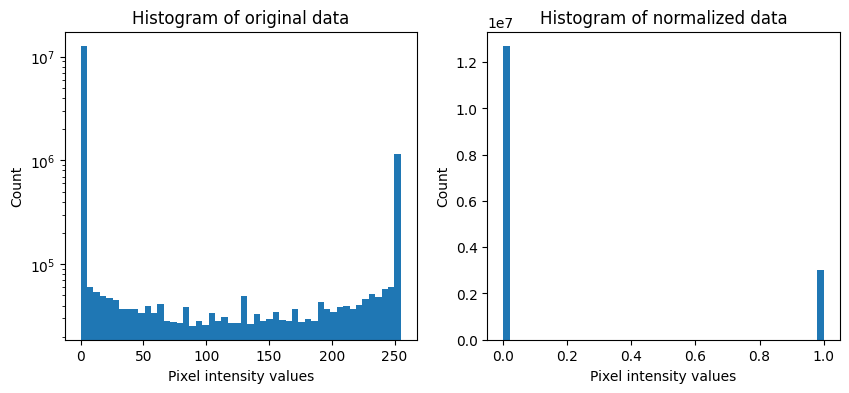

In [123]:
## 归一化到[0,1] 之间
# dataNorm = data/np.max(data)
dataNorm = (data > 0).astype(float)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')


plt.show()



In [124]:
print(np.unique(data))
print('')
print(np.unique(dataNorm))

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

In [125]:
# convert to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# use scikitlearn to split the data
train_data,test_data,train_labels,test_labels = train_test_split(dataT,labelsT,test_size=.1)

# convert into pytorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)


batchsize = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


In [126]:

def createTheMNISTNet():

    class mnistNet(nn.Module):

        def __init__(self):
            super().__init__()

            self.input = nn.Linear(784, 64)

            # hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # output layer
            self.output = nn.Linear(32, 10)

        def forward(self, x):

            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return torch.log_softmax(self.output(x), axis=1)

    net = mnistNet()

    lossfun = nn.NLLLoss()

    optimizer = torch.optim.SGD(net.parameters(),lr=.1)
     
    return net,lossfun,optimizer

In [127]:

%whos

Variable            Type             Data/Info
----------------------------------------------
DataLoader          type             <class 'torch.utils.data.dataloader.DataLoader'>
F                   module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset       type             <class 'torch.utils.data.dataset.TensorDataset'>
X                   Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
ax                  ndarray          2: 2 elems, type `object`, 16 bytes
batchsize           int              32
createTheMNISTNet   function         <function createTheMNISTNet at 0x16add7790>
data                ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm            ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT               Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
display             module       

In [128]:

net,lossfun,optimizer = createTheMNISTNet()

X,y = next(iter(train_loader))

yHat = net(X)

# 值是 各个数字的 log概率
print(yHat.shape)
# loss = lossfun(yHat,y)
# print(loss)


torch.Size([32, 10])


In [129]:

def trainTheModel():
    
    numepochs = 60
    
    net,lossfun, optimizer = createTheMNISTNet()
    losses = torch.zeros(numepochs)

    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):
        
        batchAcc = []
        batchLoss =[]

        for X,y in train_loader:
            
            yHat = net(X)
            loss = lossfun(yHat,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

            matches = torch.argmax(yHat,axis =1) == y
            matchesNumeric = matches.float()
            
            accuracyPct = 100 * torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)

        trainAcc.append(np.mean(batchAcc))

        losses[epochi] = np.mean(batchLoss)

        X,y = next(iter(test_loader))

        yHat = net(X)

        testAcc .append(100*torch.mean((torch.argmax(yHat,axis =1) == y).float()))

    return trainAcc ,testAcc,losses,net        
    

In [130]:

trainAcc,testAcc,losses,net = trainTheModel()

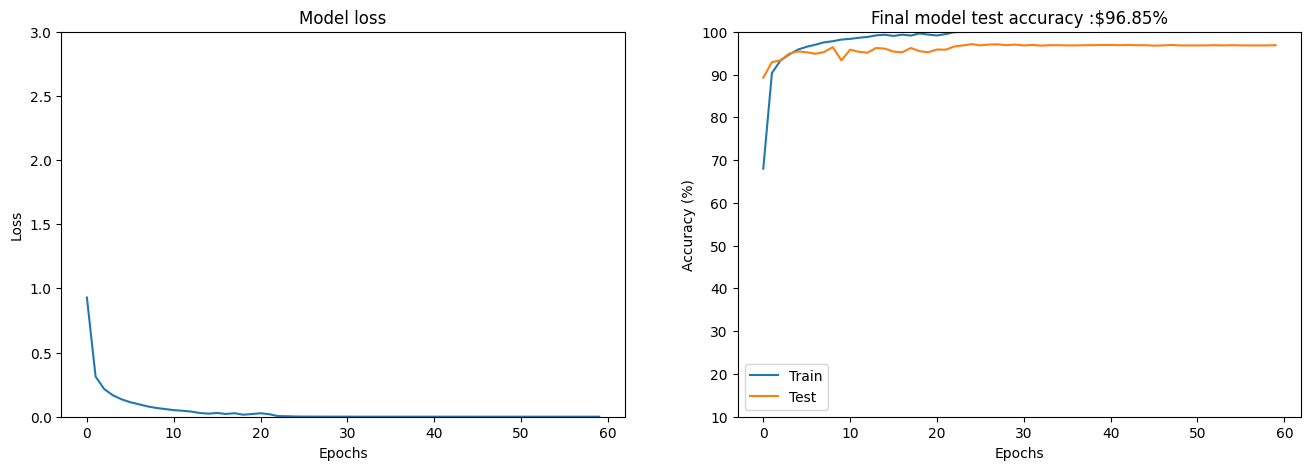

In [131]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy :${testAcc[-1]:.2f}%')
ax[1].legend()
plt.show()

In [132]:
X,y  =next(iter(test_loader))
predictions = net(X).detach()

predictions

tensor([[-2.9633e+01, -4.2776e+01, -3.1872e+01,  ...,  0.0000e+00,
         -4.7136e+01, -2.0117e+01],
        [-1.6375e+01, -1.9723e+01, -1.4897e+01,  ..., -1.4666e-03,
         -1.8866e+01, -6.5949e+00],
        [-4.2512e+01, -6.8744e+01, -6.3035e+01,  ..., -5.5789e+01,
         -3.0891e+01, -4.2879e+01],
        ...,
        [-5.7112e+01, -3.7497e+01, -3.9436e+01,  ..., -4.2912e+01,
         -3.3990e+01, -2.9014e+01],
        [-4.2128e+01, -5.9726e+01, -4.8550e+01,  ..., -4.1630e+01,
         -3.9783e+01, -4.2627e+01],
        [-3.9281e+01, -3.7829e+01, -3.0622e+01,  ..., -4.7814e+01,
         -3.1873e+01, -5.5117e+01]])

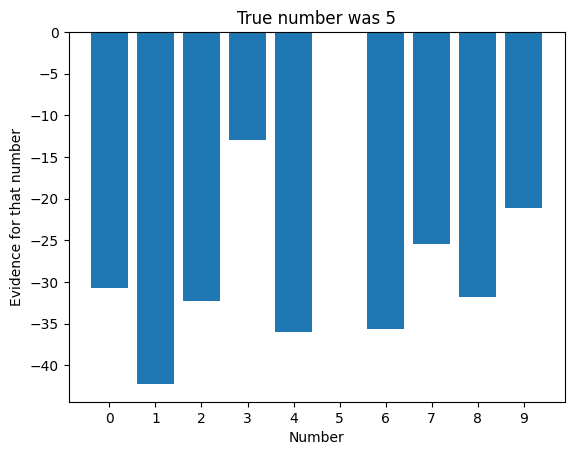

In [133]:

sample2show = 120
plt.bar(range(10),predictions[sample2show])

plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')

plt.title('True number was %s' %y[sample2show].item())
plt.show()


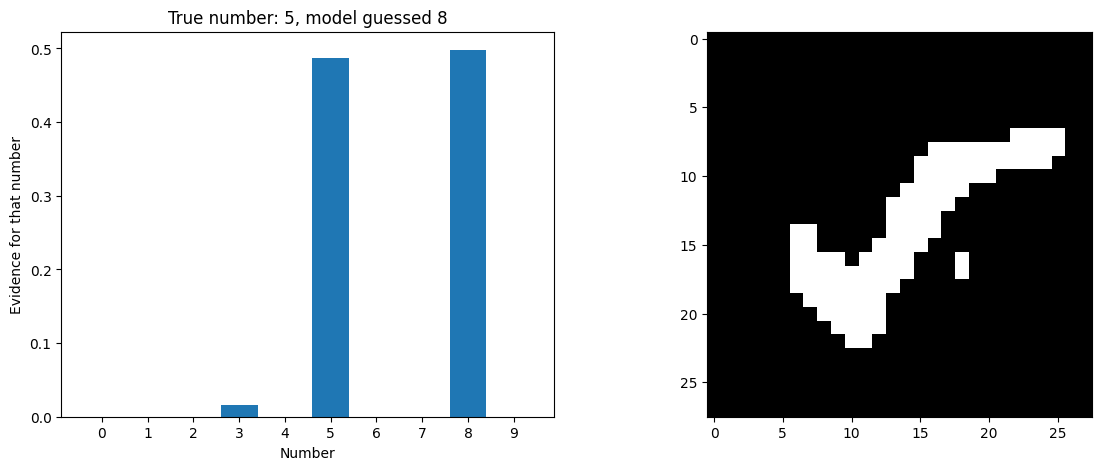

In [134]:
errors = np.where(torch.max(predictions,axis=1)[1] != y)[0]

sample2show =10

# Evidence for all numbers from one sample
sample2show = 10

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()
     